# Dealing with imbalanced data sets (credicard.csv)

In [1]:
from dtreeviz.trees import *
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, f1_score, accuracy_score,\
                            roc_auc_score, average_precision_score, precision_recall_curve, auc,\
                            roc_curve

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_boston, load_iris, load_wine, load_digits, \
                             load_breast_cancer, load_diabetes, fetch_mldata
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from copy import copy

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

In [2]:
# https://www.kaggle.com/mlg-ulb/creditcardfraud/downloads/creditcardfraud.zip/3
df = pd.read_csv("../../data/creditcard.csv")

In [3]:
print(f"num anomalies {np.sum(df['Class']==1)}/{len(df)} = {100*np.sum(df['Class']==1)/len(df):.2f}%")

num anomalies 492/284807 = 0.17%


## Choose model

In [4]:
model = RandomForestClassifier(n_estimators=10, n_jobs=-1, class_weight=None) #'balanced'
#model = LogisticRegression(solver='lbfgs', class_weight=None)

## Try usual train/test split

In [5]:
X, y = df.drop('Class', axis=1), df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)
clf = copy(model)#RandomForestClassifier(n_estimators=10, n_jobs=-1, class_weight=None) #'balanced'
clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [6]:
y_pred = clf.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
y_pred_proba = clf.predict_proba(X_test)[:,1] # 2nd column is p(fraud)
AUC = roc_auc_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba, pos_label=1)
PR = auc(recall, precision)
FPR, TPR, _ = roc_curve(y_test, y_pred_proba)
df_conf = pd.DataFrame(confusion, columns=['F','T'], index=['F','T'])
df_conf

,F,T
F,56874,1
T,26,61


In [7]:
print(f"F1 {f1_score(y_test, y_pred):.2f}, Accuracy {accuracy_score(y_test, y_pred):.2f}")
print(f"ROC {AUC:.2f}, Avg PR curve {PR:.2f}")

F1 0.82, Accuracy 1.00
ROC 0.91, Avg PR curve 0.80


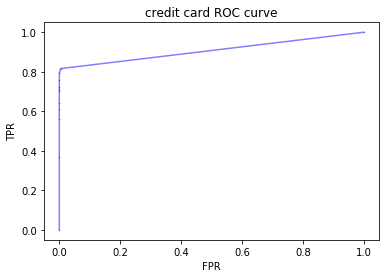

In [8]:
%config InlineBackend.figure_format = 'png'
plt.plot(FPR, TPR, 'b.-', markersize=1, alpha=0.5)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title(f"credit card ROC curve")
plt.savefig("/tmp/ROC-curve.png", dpi=200)
plt.show()
%config InlineBackend.figure_format = 'svg'

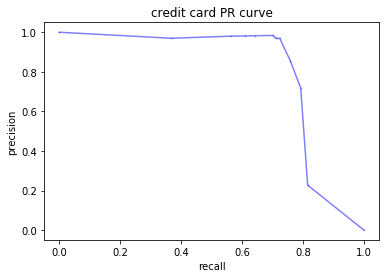

In [9]:
%config InlineBackend.figure_format = 'png'
plt.plot(recall, precision, 'b.-', markersize=1, alpha=0.5)
plt.xlabel("recall")
plt.ylabel("precision")
plt.title(f"credit card PR curve")
plt.savefig("/tmp/PR-curve.png", dpi=200)
plt.show()
%config InlineBackend.figure_format = 'svg'

## Split out proper test set

In [10]:
# must split out test set first but get 20% from each class at original ratio of fraud/good
df_good = df[df['Class']==0]
df_fraud = df[df['Class']==1]

df_train_good, df_test_good   = train_test_split(df_good, test_size=0.20)
df_train_fraud, df_test_fraud = train_test_split(df_fraud, test_size=0.20)

df_train = pd.concat([df_train_good, df_train_fraud], axis=0)
df_test  = pd.concat([df_test_good, df_test_fraud], axis=0)

print(f"TRAIN num fraud {np.sum(df_train['Class']==1)}/{len(df_train)} = {100*np.sum(df_train['Class']==1)/len(df_train):.2f}%")
print(f"TEST num fraud {np.sum(df_test['Class']==1)}/{len(df_test)} = {100*np.sum(df_test['Class']==1)/len(df_test):.2f}%")

TRAIN num fraud 393/227845 = 0.17%
TEST num fraud 99/56962 = 0.17%


In [11]:
X_train, y_train = df_train.drop('Class', axis=1), df_train['Class']
X_test, y_test = df_test.drop('Class', axis=1), df_test['Class']
clf = copy(model)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
df_conf = pd.DataFrame(confusion, columns=['F','T'], index=['F','T'])
df_conf

,F,T
F,56855,8
T,19,80


In [12]:
y_pred_proba = clf.predict_proba(X_test)[:,1] # 2nd column is p(fraud)
AUC = roc_auc_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba, pos_label=1)
PR = auc(recall, precision)
print(f"F1 {f1_score(y_test, y_pred):.2f}, Accuracy {accuracy_score(y_test, y_pred):.2f}")
print(f"ROC {AUC:.2f}, Avg PR curve {PR:.2f}")

F1 0.86, Accuracy 1.00
ROC 0.94, Avg PR curve 0.87


## Oversample fraud

In [13]:
# Now, upsample the fraud records in training set
df_good = df_train[df_train['Class']==0]
df_fraud = df_train[df_train['Class']==1]

df_fraud_balanced = df_fraud.sample(int(len(df_fraud)*10), replace=True)
df_train_upsampled = pd.concat([df_good, df_fraud_balanced], axis=0)
print(f"Upsampled TRAIN num fraud {np.sum(df_train_upsampled['Class']==1)}/{len(df_train_upsampled)} = {100*np.sum(df_train_upsampled['Class']==1)/len(df_train_upsampled):.2f}%")
print(f"TEST num fraud {np.sum(df_test['Class']==1)}/{len(df_test)} = {100*np.sum(df_test['Class']==1)/len(df_test):.2f}%")

Upsampled TRAIN num fraud 3930/231382 = 1.70%
TEST num fraud 99/56962 = 0.17%


In [14]:
X_train, y_train = df_train_upsampled.drop('Class', axis=1), df_train_upsampled['Class']
X_test, y_test = df_test.drop('Class', axis=1), df_test['Class']
clf = copy(model)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
df_conf = pd.DataFrame(confusion, columns=['F','T'], index=['F','T'])
df_conf

,F,T
F,56858,5
T,19,80


In [15]:
y_pred_proba = clf.predict_proba(X_test)[:,1] # 2nd column is p(fraud)
AUC = roc_auc_score(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba, pos_label=1)
PR = auc(recall, precision)
print(f"F1 {f1_score(y_test, y_pred):.2f}, Accuracy {accuracy_score(y_test, y_pred):.2f}")
print(f"ROC {AUC:.2f}, Avg PR curve {PR:.2f}")

F1 0.87, Accuracy 1.00
ROC 0.95, Avg PR curve 0.88


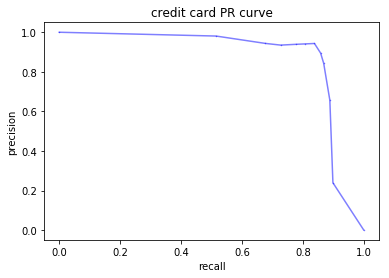

In [16]:
%config InlineBackend.figure_format = 'png'
plt.plot(recall, precision, 'b.-', markersize=1, alpha=0.5)
plt.xlabel("recall")
plt.ylabel("precision")
plt.title(f"credit card PR curve")
plt.savefig("/tmp/PR-curve-balanced.png", dpi=200)
plt.show()
%config InlineBackend.figure_format = 'svg'